In [152]:
import numpy as np
#import HERA_hack
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy.linalg as la
from scipy import signal

# Far Away Point Source

In [6]:
psource_flux = [100,1235,2348,98,22]
pbeam = 1

for i in range(len(psource_flux)):
    if psource_flux[i]*pbeam <= 100:
        pass
    else:
      continue          

## 1. Locating the source

In [9]:

dishes = np.array([[0,0],[0,55],[30,30],[0,60],[2,55],[47,2],[45,23],[56,21],[30,115],[48,52],[100,100],[0,200],[115,30],[33,31],[49,11],[21,24],[25,6],[56,9],[12,13],[16,17],[38,17],[60,14],[26,28],[6,45],[3,37],[12,55],[200,0],[145,13],[134,65],[139,163]])

#observable corners of the sky [lat,long]
acorner = np.array([[120,270],[122,280],[120,280],[122,270]])

HERA = HERA_hack.telescope(dishes, latitude=-30, channel_width=1., Tsys=300, beam_width=3, beam = 'gaussian')

obs = HERA_hack.observation(HERA, 100, 100, 0.01,acorner,1, 0.2, norm = False, pbeam = False)

noise = obs.generate_map_noise()

In [66]:
r = [2.02,4.6] #location of source in rads 
thetas = r[0]
phis = r[1]

#convert to 3d
transformed = np.zeros((1, 3))
transformed[0,0] = np.sin(thetas)*np.cos(phis)#X
transformed[0,1] = np.sin(thetas)*np.sin(phis)#Y
transformed[0,2] = np.cos(thetas)#Z

print(transformed)
obs.convert_to_3d()
x = [(1,2),(4,6),(7,5)]
y = (3,3)

x.append(y)

def takeSecond(elem):
    return elem[1]


x.sort(key = takeSecond)

arr = np.array((-0.1, -0.89, -0.45))
arr = np.reshape(arr,(1,3))

def truth(transformed,arr):
    if transformed.all() == arr.all():
        return True 
    else: 
        return False
    
truth(transformed,arr)

[[-0.10102623 -0.89511009 -0.43424835]]


True

## 2. Compute Bdotr

In [31]:
bdotr = np.dot(obs.bl_times, transformed.T)

wavelength = (3e8)/float(100*1e6)

exponent = np.exp(-1j * 2 * np.pi*(bdotr/ float(wavelength)))

A = obs.pbeam * exponent

A.shape

(1305, 1500)

## 3. Convolve Map

In [153]:
#these are for the telescope and observation
import numpy as np 
import numpy.linalg as la
import seaborn as sns
import pandas as pd
import os
from scipy import signal
from timeit import default_timer as timer
import scipy.constants as sc



class telescope(object):
    """
    Object to store the properties of the telescope, including:
    ---Telescope location
    ---Array configuration
    ---Primary beam
    """
    def __init__(self, ant_locs, latitude, channel_width, Tsys, beam_width, beam='gaussian'):
        self.ant_locs = ant_locs # (Nants,2) sized array # relative position in meters 
        self.latitude = latitude # degrees this is the central latitute of the HERA strip 
        self.latitude *= np.pi / 180. # radians
        self.channel_width = channel_width # assume Hz
        self.Tsys = Tsys # assume Kelvin
        if beam != 'gaussian':
            raise NotImplementedError()
        else:
            self.beam = beam
            self.beam_width = beam_width # FWHM in degrees
            self.beam_width *= np.pi / 180. # FWHM in radians


    def compute_2D_bls(self): #DO NOTE RETURN
        """
        Computes the 2D ("uv plane") baselines for a local coordinate
        system when the observations started.
        """
        N_ants = self.ant_locs.shape[0]
        N_bls = int(N_ants * (N_ants - 1) / 2.) #this is the total number of baselines, redundant included
        self.bls = np.zeros((N_bls,2)) # initialize a list holding the length of all the baselines 
        k = 0 #initialize this k variable
        for i in range(N_ants):
            ant_i = self.ant_locs[i]
            for j in range(i+1,N_ants):
                ant_j = self.ant_locs[j]
                self.bls[k] = ant_i - ant_j # this subtracts each coordinate from the other [0,0]-[1,1]
                k += 1 #add k every time you identify a baseline 
                
                
    def remove_redundant_bls(self): #DO NOT RETURN
        """
        Removes redundant baselines. Information is preserved by
        storing a multiplicity array.
        """
        self.compute_2D_bls()
        self.bls, self.ucounts = np.unique(self.bls, axis=0, return_counts=True) #picking out only unique bls
        self.N_bls= len(self.bls) # number of unique pairs of baselines

    
    def compute_celestial_bls(self):#REUTRN bls_celestial
        """
        Computes a 3D distribution of baselines in a coordinate
        system fixed to the celestial sphere.
        """
        # First define the rotation matrix that gets baselines
        # to the correct latitude for the array
        #rotate about the z axis 
        self.remove_redundant_bls()
        
        co_lat = (np.pi / 2.) - self.latitude 
        cos_co_lat = np.cos(co_lat)
        sin_co_lat = np.sin(co_lat)
        lat_rot_matrix = np.array([[1., 0., 0.], #X
                                  [0., cos_co_lat, -sin_co_lat], #Y
                                  [0., sin_co_lat, cos_co_lat]]) #Z


        # Add a z coordinate to the 2D baseline vectors 
        self.bls_celestial = np.vstack((self.bls.T, np.zeros(self.N_bls)))
       
        # Rotate them! 
        self.bls_celestial = np.dot(lat_rot_matrix, self.bls_celestial) #3 x N_bls array
        
        return self.bls_celestial 

class observation(object):
    """
    Object that stores all the sky information 
    """

    def __init__(self, telescope, n_days, freq, delta_t, corners, beam_sigma_cutoff, resol,norm,pbeam):
        self.times = None # in days
        self.position = None# observable corners (theta, phi)
        self.bl_times = None
        self.norm = None
        self.corners = corners# corners has to be the four corner of the sky (theta, phi) [4,2]
        self.beam_sigma_cutoff = beam_sigma_cutoff
        self.telescope = telescope
        self.n_days = n_days # Number of cycles of the observation
        self.delta_t = delta_t #length of time steps 
        #self.effarea = effarea # Effective area of an antenna
        self.normalization = norm #indicate whether to include normalization in mapping
        self.primary_beam = pbeam #indicate whether to include pbeam in Amatrix
        
        self.beam_width = telescope.beam_width
        self.beam = telescope.beam
        self.ant_locs = telescope.ant_locs
        self.latitude = telescope.latitude
        self.channel_width = telescope.channel_width
        self.Tsys = telescope.Tsys
        self.bls_celestial = telescope.compute_celestial_bls()
        self.ucounts = telescope.ucounts # number of unique baselines
        
        self.freq = freq #MHz
        self.resol = resol # deg
        self.resol *= np.pi/180.
        
        self.Nbl = self.bls_celestial.shape[1]
        

    def observable_coordinates(self): #RETURN self.position
        """
        Find the observable coordinates given the four corners of a patch
        """
        s = self.corners.shape
        if s[0] != 4:
            raise ValueError('Four coordinates should be provided')
        elif s[1] != 2:
            raise ValueError('Input has to be RA & Dec')
            
        beam_minus, beam_plus = np.array([-1, +1])*self.beam_width*self.beam_sigma_cutoff
        min_corner = np.min(self.corners, axis=0)
        max_corner = np.max(self.corners, axis=0)
        min_obsbound = self.latitude + beam_minus #Here we're computing the size of the observing window
        max_obsbound = self.latitude + beam_plus #bigger beam_width or sigma_cutoff means a larger observing window 
        #print(min_obsbound*180./np.pi,max_obsbound*180./np.pi)
        # Now convert from latitude (measured from the equatorial plane up)
        # to the polar angle (measured down from the z axis)
        # Note how "max" and "min" swap places here
        max_swap = max_obsbound
        max_obsbound = np.pi / 2. - min_obsbound 
        min_obsbound = np.pi / 2. - max_swap
        
        if max_corner[0]*(np.pi/180.) < min_obsbound or min_corner[0]*(np.pi/180.) > max_obsbound:
            raise ValueError('Requested Region is not observable')
        else:
            #print(min_obsbound*180./np.pi, max_obsbound*180./np.pi)
            #print((min_corner[1]), (max_corner[1]))
            #print(self.resol)
            #assert False
            thetas = np.arange(min_obsbound, max_obsbound, self.resol) 
            phis = np.arange((min_corner[1]*(np.pi/180.)), (max_corner[1]*(np.pi/180.)), self.resol)
            #print(thetas*180./np.pi)
            #print(phis*180./np.pi)
            
            self.position = np.concatenate(np.dstack(np.meshgrid(thetas, phis)))
            self.Npix = self.position.shape[0]
            
            
        return self.position
        

    def necessary_times(self): #REUTRN self.times
        """
        Assuming Phi = 0h at phi coordinate of observable region(self.potion), 
        Figure out time when the telescope scanning and observable region overlaps
        """

        if self.position is not None:
            pass
        else:
            self.position = self.observable_coordinates() 
            
        time_length = np.abs(self.position[self.position.shape[0]-1,1]-self.position[0,1])/ (np.pi*2.)#fraction of roation you've completed in observing window
        
        self.times = np.arange(0., time_length, self.delta_t)#units here odn't make sense
        self.Nt = len(self.times) #this is the number of times the telescope makes an observation
        return self.times # in fraction of circle
    

    def rotate_bls(self): #DO NOT RETURN
        """
        Rotates the baselines to their correct positions given
        the observation times. Results are stored in a bl-time array.
        """

        if self.times is not None:
            pass
        else:
            self.times = self.necessary_times()
        
        # Radians rotated since beginning of observation    
        phis = (2. * np.pi * self.times) 
        
        # Define rotation matrices about z axis
        cos_phis = np.cos(phis)
        sin_phis = np.sin(phis)
        
        
        time_rot_matrices = np.zeros((self.times.shape[0], 3, 3))
        time_rot_matrices[:,-1,-1] = 1.
        for i in range(self.times.shape[0]): 
            time_rot_matrices[i,0,0] = cos_phis[i]
            time_rot_matrices[i,0,1] = -sin_phis[i]
            time_rot_matrices[i,1,0] = sin_phis[i]
            time_rot_matrices[i,1,1] = cos_phis[i]

        # Multiply baselines by rotation matrices
        # Result is a N_times x 3 x N_bls matrix
        
        self.bl_times = np.dot(time_rot_matrices, self.bls_celestial)
        self.bl_times = np.moveaxis(self.bl_times, -1, 0) # now N_bls x N_t x 3
        
        self.bl_times = np.reshape(self.bl_times, (-1,3)) #TESTED
        # now N_bls N_t x 3, where we cycle through times more quickly
        
    def convert_to_3d(self): #RETURN transformed
        """
        Project the patch of the sky (Equatorial coord) onto 
        the baseline coordinate (3D) for calibration
        """
        
        if self.position is not None:
            pass
        else:
            self.observable_coordinates()
        
        thetas = self.position[:,0]
        phis = self.position[:,1]
        #print(thetas[:10]*180./np.pi,phis[:10]*180./np.pi)
        transformed = np.zeros((self.Npix, 3))
        
        for i in range(self.Npix): 
            transformed[i,0] = np.sin(thetas[i])*np.cos(phis[i])#X
            transformed[i,1] = np.sin(thetas[i])*np.sin(phis[i])#Y
            transformed[i,2] = np.cos(thetas[i])#Z
            
        return transformed 
        
    
    def compute_bdotr(self): #DO NOT RETURN
        #(self, p_source_data)
        """
        Given an array of times and sky positions,
        computes an (N_times,N_pos) array
        containing b-dot r.
        """

        if self.bl_times is not None: 
            pass
        else:
            self.rotate_bls()
            
        
        position3d = self.convert_to_3d()
        
        r_source = np.array((-0.1, -0.89, -0.45)) #IRL we would read these coord in from FG code 
        r_source = np.reshape(,(1,3))
        
        position3d = np.concatenate((position3d, r_source), axis=0)
        
        # (N_bls N_t x 3  ) (3 x npix)

        # Result is a N_t N_bl x (N_pix+n_sources) array
        # Cycles through time more rapidly than baselines
        self.bdotr = np.dot(self.bl_times, position3d.T) #TESTED
        

    def compute_beam(self): #DO NOT RETURN
        """
        Compute Primary Beam assuming all antenna has an identical beam with the fixed sky.
        """

        if self.times is not None:
            pass
        else:
            self.times = self.necessary_times()

        phis = (2. * np.pi * self.times) + self.position[0,1] #convert back to from times to phi, shifting back to initial phi coord
       

        if self.beam == 'gaussian':
            primary = np.zeros((self.Nt, self.Npix))
            
            co_lat = np.pi / 2. - self.latitude

            for i in range(self.Nt): #compute the elements of pbeam
                primary[i] = np.exp(-((self.position[:,1]-phis[i])**2 +(self.position[:,0]-co_lat)**2) / float(self.beam_width**2))# 2D gaussian beam (N_position,2)
        
        else:
            raise NotImplementedError()
        
        # assume primary beam is same for all baselines
        # Want self.pbeam to have shape N_t N_bl x Npix
        # where we cycle rapidly through time

        self.pbeam = np.vstack([primary] * self.Nbl) #to replace the for loop pbeam
        
        
    def compute_Amat(self): #DO NOT RETURN
        """
        Compute A matrix
        """
        if self.times is not None:
            pass
        else:   
            self.times = self.necessary_times()
            
        self.compute_beam()
        self.compute_bdotr()
        
        wavelength = (3e8)/float(self.freq*1e6) # in m

        exponent = np.exp(-1j * 2 * np.pi*(self.bdotr/ float(wavelength)))
        ## A has shape of Nt Nbl x N_pix
        ## cycling through time more rapidly
        pix_size = self.resol ** 2
        
      
        if self.primary_beam == True: #the compute Amat with pbeam 
            
            self.Amat = self.pbeam*exponent
            
        elif self.primary_beam == False: # this computes Amat without the pbeam
            self.Amat = exponent
            
        else: 
            raise ValueError('You should indicate the use of a primary beam')
        

        self.noise_rms =  self.Tsys / np.sqrt(2*self.n_days*self.delta_t * self.channel_width)
        self.invN = np.diag(np.repeat(self.ucounts, self.Nt)) * (1/float((self.noise_rms)**2)) #Nt N_unique_bls x Nt N_unique_bls diagonal array
        
        

    def compute_vis(self, vec): #DO NOT RETURN
        """
        Compute visibility from given vector
        """
        self.compute_Amat()
        
        #vector = np.concatenate((vec, psource fluxes),axis=0)
    
        self.Adotx = np.dot(self.Amat, vec) 
    
    

    def compute_normalization(self): #DO NOT RETURN

        ## compute [A^*t N^{-1} A]^{-1}
        self.compute_Amat()
                          
        AtA = ((np.conj(self.Amat)).T).dot(self.invN).dot(self.Amat)
        
    
        #here we are setting all the non-diagonal elements of AtA to 0
        
        diagAtA = np.diag(AtA) #pick out the main diagonal
    
        matrix_diagAtA = np.diag(diagAtA) #make that diagonal into a diagonal matrix
    
        self.norm = la.inv(matrix_diagAtA) #take the diagonal matrix and take the inverse 

    def generate_map_noise(self):#DO NOT RETURN
        """
        Draw Gaussian random white noise from noise rms
        Returns to normalized noise prediction
        """

        if self.norm is not None:
            pass
        else:
            self.compute_normalization()
                   

        self.my_noise = np.random.randn(self.Nt*self.Nbl) + np.random.randn(self.Nt*self.Nbl)*(1j)
        
        if self.normalization == True: #uses the normalization in the estimator


            self.noise = np.dot(self.norm,(np.conj(self.Amat)).T).dot(self.invN).dot(self.my_noise)

            return self.noise

        else: 

            self.noise = (np.conj(self.Amat)).T.dot(self.invN).dot(self.my_noise)
 
            return self.noise




    def convolve_map(self, vec): #DO NOT RETURN
        
        
        """
        Normalized Sky Prediction
        """

        #start timine here 
        #start = timer()

        if self.norm is not None:
            pass
        else:
            self.compute_normalization()
        self.compute_vis(vec)
        
        
        if self.normalization == True: #uses the normalization in the estimator
            
            self.map = np.dot(self.norm,((np.conj(self.Amat)).T).dot(self.invN).dot(self.Adotx))
            
            #end timer here
            return self.map 
            # end = timer()
            # runtime = end-start
            # return runtime
            
        else: #leaves out the normalization 
            self.map = ((np.conj(self.Amat)).T).dot(self.invN).dot(self.Adotx)
        
            return self.map
            # end = timer()
            # runtime = end-start
            # return runtime 

In [171]:
HERA1 = telescope(dishes, latitude=-30, channel_width=1., Tsys=300, beam_width=3, beam = 'gaussian')
obs_1 = observation(HERA1, 100, 100, 0.01,acorner,1, 0.2, norm = False, pbeam = False)


nsources = 1
npix = len(obs.observable_coordinates())
mid_pixel = np.int(npix*0.5098507)
imp = (10*signal.unit_impulse((npix+1), npix)) 
imp_s =  signal.unit_impulse(npix+1, mid_pixel) 
imp_both = imp + imp_s
obs_1.convolve_map(imp)[:1500]

array([-0.00185656+0.00874434j,  0.00080923+0.00932029j,
        0.00294732+0.00466258j, ..., -0.00943118+0.00192475j,
       -0.009311  +0.00341307j, -0.00838518+0.0037712j ])

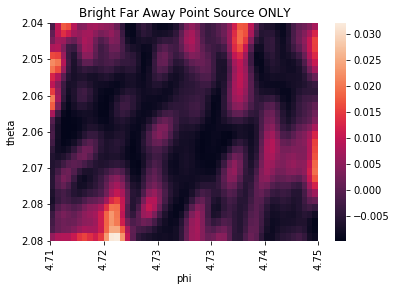

In [173]:

psource = np.real(obs_1.convolve_map(imp)[:1500])
image = np.real(obs_1.convolve_map(imp_s)[:1500])
summed = psource + image
both = np.real(obs_1.convolve_map(imp_both)[:1500])
#making separate arrays of theta and phi for data vis
x = np.zeros(npix)
y = np.zeros_like(x)

for i in range(len(obs.observable_coordinates())):
    x[i]= obs.observable_coordinates()[i,1] #phi
    y[i] = obs.observable_coordinates()[i,0]#theta


df_obs = pd.DataFrame.from_dict(np.array([x,y,psource]).T)
df_obs.columns = ['phi','theta','temp']



pivotted_obs= df_obs.pivot('theta','phi','temp')

ax = plt.axes()

sns.heatmap(pivotted_obs,ax=ax)


ax.set_title('Bright Far Away Point Source ONLY', y = 1.04)
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
ax.yaxis.set_major_locator(plt.MaxNLocator(6))
xlabels = [item.get_text() for item in ax.get_xticklabels()]
ylabels = [item.get_text() for item in ax.get_yticklabels()]
ax.set_xticklabels([str(round(float(label), 2)) for label in xlabels])
ax.set_yticklabels([str(round(float(label), 2)) for label in ylabels])

plt.show()

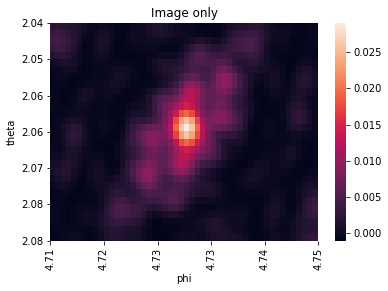

In [174]:
df_obs = pd.DataFrame.from_dict(np.array([x,y,image]).T)
df_obs.columns = ['phi','theta','temp']



pivotted_obs= df_obs.pivot('theta','phi','temp')

ax = plt.axes()

sns.heatmap(pivotted_obs,ax=ax)


ax.set_title('Image only', y = 1.04)
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
ax.yaxis.set_major_locator(plt.MaxNLocator(6))
xlabels = [item.get_text() for item in ax.get_xticklabels()]
ylabels = [item.get_text() for item in ax.get_yticklabels()]
ax.set_xticklabels([str(round(float(label), 2)) for label in xlabels])
ax.set_yticklabels([str(round(float(label), 2)) for label in ylabels])

plt.show()

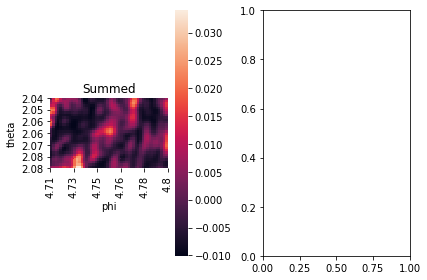

In [207]:
df_obs = pd.DataFrame.from_dict(np.array([x,y,summed]).T)
df_obs.columns = ['phi','theta','temp']
pivotted_obs= df_obs.pivot('theta','phi','temp')

df_obs_both = pd.DataFrame.from_dict(np.array([x,y,both]).T)
df_obs_both.columns = ['phi','theta','temp']
pivotted_obs_both= df_obs.pivot('theta','phi','temp')

fig, axs = plt.subplots(1,2)

sns.heatmap(pivotted_obs,ax=axs[0])


axs[0].set_title('Summed', y = 1.04)
axs[0].xaxis.set_major_locator(plt.MaxNLocator(6))
axs[0].yaxis.set_major_locator(plt.MaxNLocator(6))
xlabels = [item.get_text() for item in axs[0].get_xticklabels()]
ylabels = [item.get_text() for item in axs[0].get_yticklabels()]
axs[0].set_xticklabels([str(round(float(label), 2)) for label in xlabels])
axs[0].set_yticklabels([str(round(float(label), 2)) for label in ylabels])
axs[0].set_aspect(aspect = 'equal')

sns.heatmap(pivotted_obs_both,ax=ax2)


ax2.set_title('Both', y = 1.04)
ax2.xaxis.set_major_locator(plt.MaxNLocator(6))
ax2.yaxis.set_major_locator(plt.MaxNLocator(6))
xlabels = [item.get_text() for item in ax1.get_xticklabels()]
ylabels = [item.get_text() for item in ax1.get_yticklabels()]
ax2.set_xticklabels([str(round(float(label), 2)) for label in xlabels])
ax2.set_yticklabels([str(round(float(label), 2)) for label in ylabels])

plt.tight_layout()
plt.show()